In [357]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as sts
from tqdm import tqdm
from scipy.stats import mannwhitneyu
import statsmodels.api as sm


In [336]:
df = pd.read_csv('/Users/vladimiregorov/Downloads/cookie_cats.csv')

In [337]:
df.head(2)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False


In [338]:
df.dtypes

userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object

Переведем значение по retention в числовой тип

In [339]:
df['retention_1'] = df['retention_1'].astype(int)
df['retention_7'] = df['retention_1'].astype(int)

In [340]:
df['version'].value_counts()

version
gate_40    45489
gate_30    44700
Name: count, dtype: int64

In [341]:
df.isna().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

у нас с данными все впорядке. 

Предположим , что `gate_30` это контрольная выборка , а `gate_40` - тестовая. 

In [361]:
dataA = df[df['version'] == 'gate_30']
dataB = df[df['version'] == 'gate_40']

построим боксплот по `sum_gamerounds`

<function matplotlib.pyplot.show(close=None, block=None)>

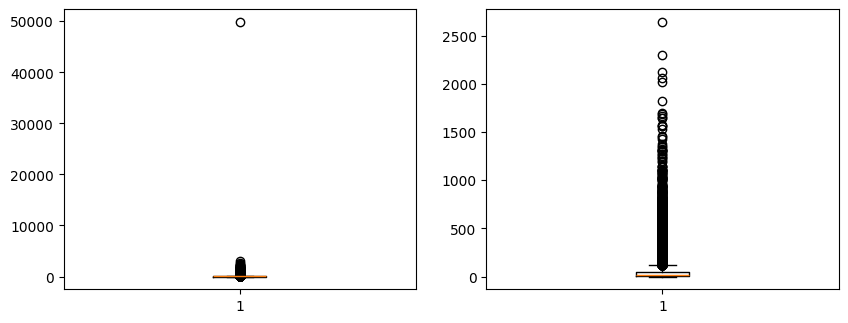

In [343]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(2,2,1)
ax.boxplot(df['sum_gamerounds'])

ax1 = fig.add_subplot(2,2,2)
ax1.boxplot(dataB['sum_gamerounds'])

plt.show

видим выбросы , избавимся от них : 

<function matplotlib.pyplot.show(close=None, block=None)>

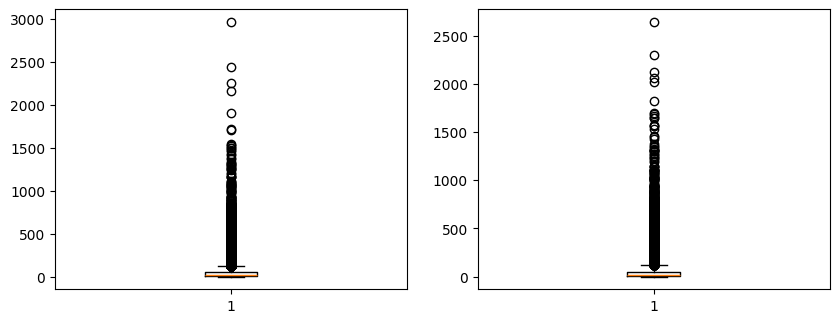

In [344]:
dataA = dataA[dataA['sum_gamerounds'] < 40000]
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(2,2,1)
ax.boxplot(dataA['sum_gamerounds'])

ax1 = fig.add_subplot(2,2,2)
ax1.boxplot(dataB['sum_gamerounds'])
plt.show

видим , что группы распределены равномерно как в тестовой , так и в контрольной группе : 

<function matplotlib.pyplot.show(close=None, block=None)>

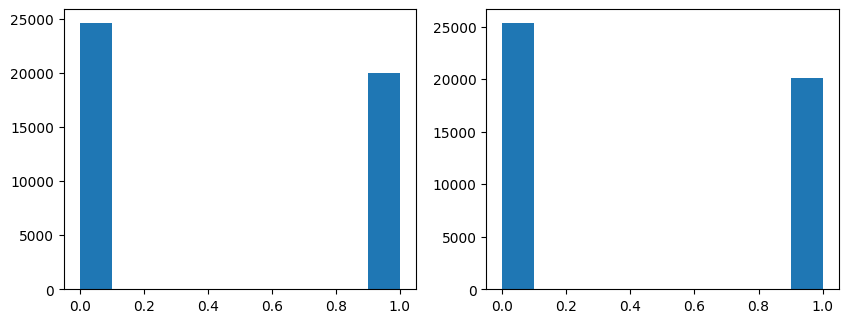

In [345]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(2,2,1)
ax.hist(dataA['retention_1'])

ax1 = fig.add_subplot(2,2,2)
ax1.hist(dataB['retention_1'])

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

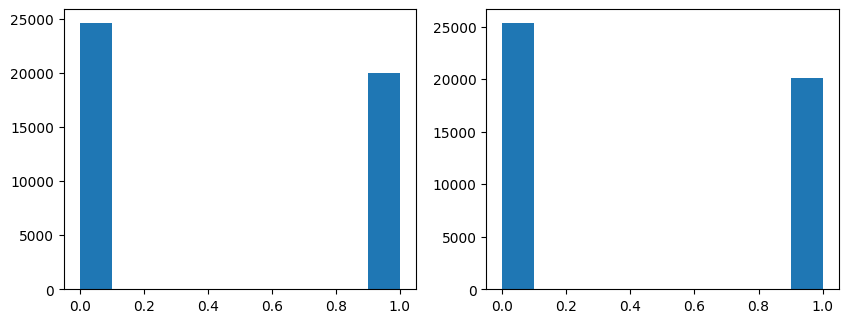

In [346]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(2,2,1)
ax.hist(dataA['retention_7'])

ax1 = fig.add_subplot(2,2,2)
ax1.hist(dataB['retention_7'])

plt.show

# Test for one-day retention

итак , для начала проверим есть ли у нас статистически значимые результаты по однодневнему ретеншину. 

Сначала проведем тест используя `бутстрап` , затем `z-test` для пропорций. 

#### Бутстрап

используем следующую формулу : 

$$
t_i = \frac{\hat{\theta}^*_i - \hat{\theta}}{\hat{SE}^*_i }
$$

$$
[\hat{\theta} - t_{1 - \alpha} * se(\hat{\theta}) ; \hat{\theta} - t_{\alpha} * se(\hat{\theta})]
$$

In [366]:
meana = dataA['retention_1'].mean()
meanb = dataB['retention_1'].mean()

sea = dataA['retention_1'].std() / np.sqrt(len(dataA))
seb = dataB['retention_1'].std() / np.sqrt(len(dataB))

print(meana)
print(meanb)

0.4481879194630872
0.44228274967574577


/opt/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


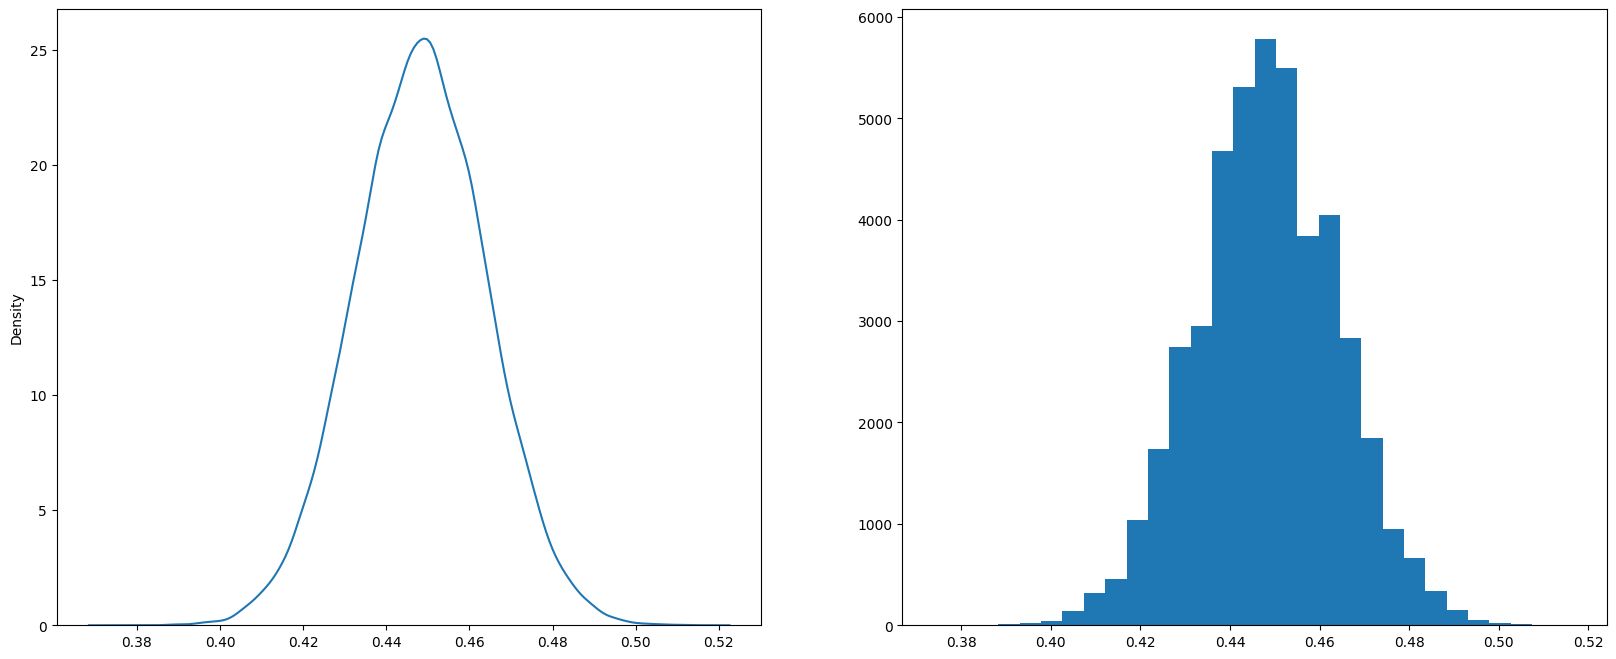

In [367]:
meanA = []


d = np.random.choice(dataA['retention_1'], size = (45489,1000), replace = True)

for i in d:
    mean = i.mean()
    meanA.append(mean)


SEa = d.std(axis = 1) / np.sqrt(len(d))
    

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1,2,1)
sns.kdeplot(meanA)

ax1 = fig.add_subplot(1,2,2)
ax1.hist(meanA, bins=30)

plt.show()

/opt/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


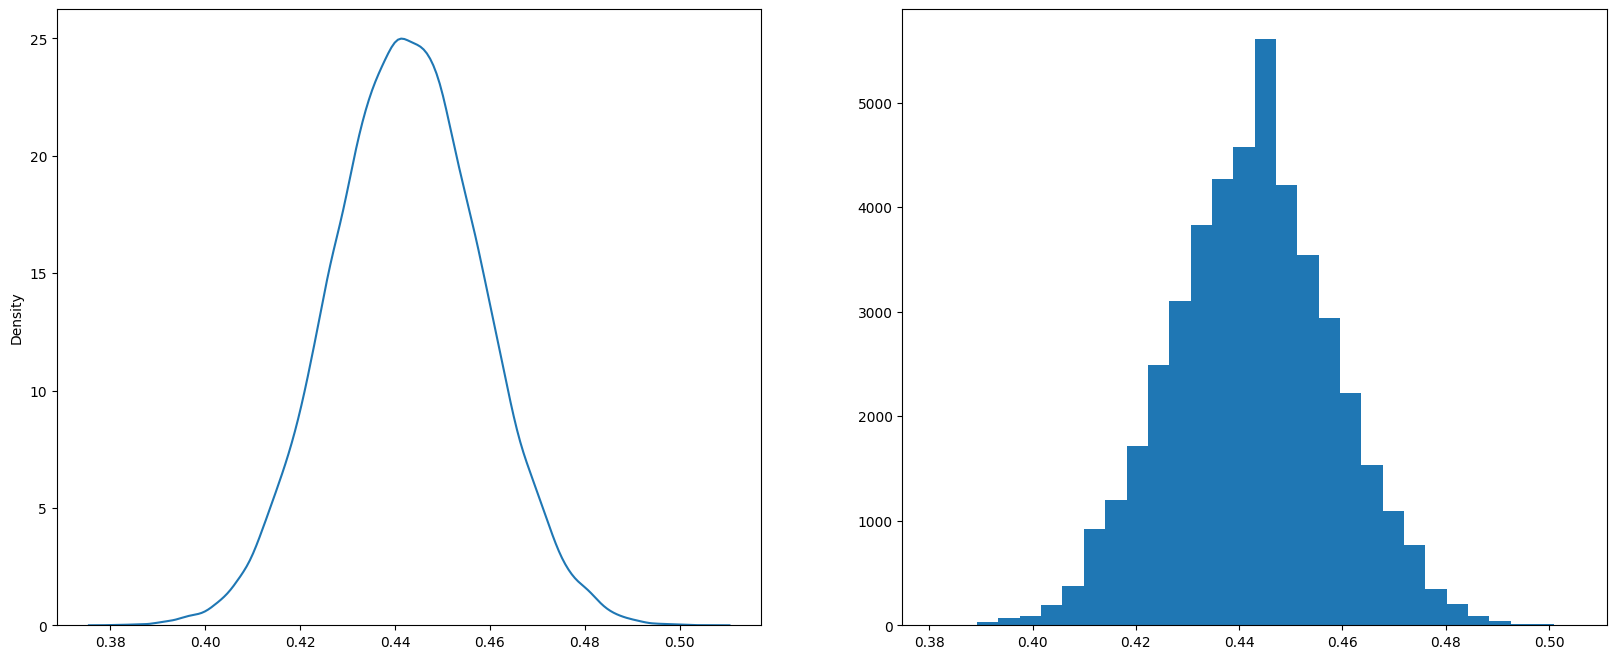

In [368]:
meanB = []


d = np.random.choice(dataB['retention_1'], size = (45489,1000), replace = True)

for i in d:
    mean = i.mean()
    meanB.append(mean)

SEb = d.std(axis = 1) / np.sqrt(len(d))
    

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1,2,1)
sns.kdeplot(meanB)

ax1 = fig.add_subplot(1,2,2)
ax1.hist(meanB, bins=30)

plt.show()

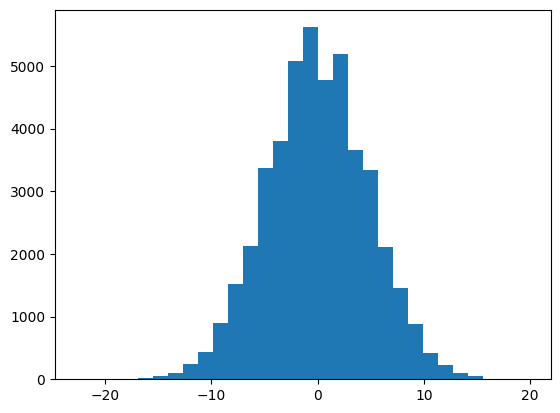

In [371]:
t_value =  ((np.array(meanA) - np.array(meanB)) - (meana - meanb)) / (np.array(SEa) + np.array(SEb))
t_value = list(t_value)
plt.hist(t_value, bins=30)
plt.show()

In [372]:
s_error = sea + seb

In [373]:
left = (meana - meanb) - np.quantile(t_value, 1-0.05/2)*s_error
right = (meana - meanb) - np.quantile(t_value, 0.05/2)*s_error

print(left)
print(right)

-0.037490557486679184
0.049876386827980033


Мы видим , что нуль лежит в нашем интервале , что говорит о том , что мы не отклоняем нулевую гипотезу , а значит статистической разницы нет. 

Проведем еще один тест. Это будет `z-test` для пропорций. 

In [375]:
contingency_table = pd.crosstab(df['version'], df['retention_1'])
contingency_table

retention_1,0,1
version,,
gate_30,24666,20034
gate_40,25370,20119


In [377]:
success_A = contingency_table[0][1]
success_B = contingency_table[1][1]

trials_A = contingency_table[0][1] + contingency_table[0][0]
trials_B = contingency_table[1][1] + contingency_table[1][0]

z_stat, p_value = sm.stats.proportions_ztest([success_A, success_B], [trials_A, trials_B], alternative = 'two-sided')
print(z_stat, p_value)

1.7840862247974685 0.0744096552969198


/var/folders/t9/p_t5rsf92s38bb58_mfpk3rm0000gn/T/ipykernel_27742/1364991551.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  success_A = contingency_table[0][1]
/var/folders/t9/p_t5rsf92s38bb58_mfpk3rm0000gn/T/ipykernel_27742/1364991551.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  success_B = contingency_table[1][1]
/var/folders/t9/p_t5rsf92s38bb58_mfpk3rm0000gn/T/ipykernel_27742/1364991551.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, us

Видим , что при $\alpha$ = 0.05 , наше `p-value` > 0.05 , таким образом мы также не отклоняем нулевую гипотезу.

# sum gamerounds 

теперь посмотрим , есть ли стастическая разница между количеством проведенных раундов. Для этого будем использовать тест манна - уитни, так как распределение у нас ненормальное. Затем снова сделаем бутстрап. 

<Axes: >

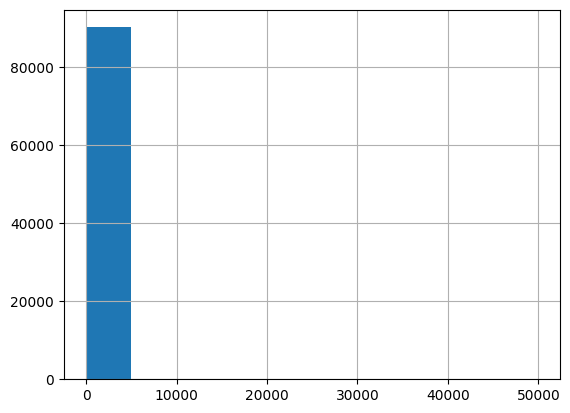

In [379]:
df['sum_gamerounds'].hist()

<function matplotlib.pyplot.show(close=None, block=None)>

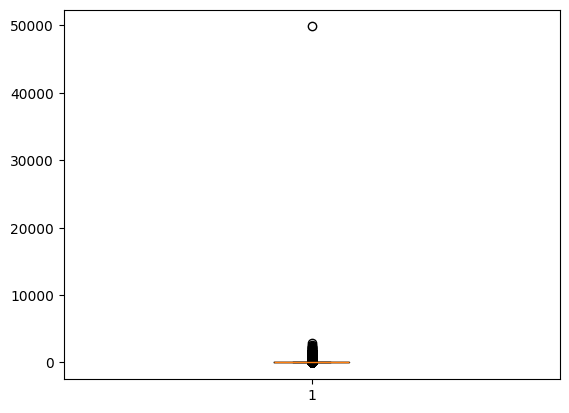

In [380]:
plt.boxplot(df['sum_gamerounds'])
plt.show

опять видим выбросы , избавимся от них : 

<function matplotlib.pyplot.show(close=None, block=None)>

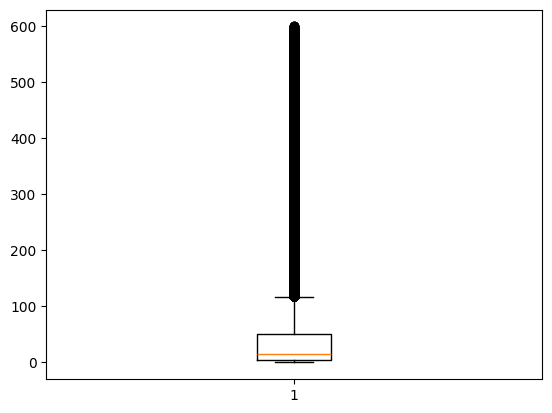

In [396]:
df = df[df['sum_gamerounds'] < 600]
plt.boxplot(df['sum_gamerounds'])
plt.show

по той же схеме , разделим на тестовую и контрольную выборку : 

In [397]:
dfA = df.loc[df['version'] == 'gate_30', 'sum_gamerounds']
dfB = df.loc[df['version'] == 'gate_40', 'sum_gamerounds']

посмотрим на распределения тестовой и контрольной выборки : 

<function matplotlib.pyplot.show(close=None, block=None)>

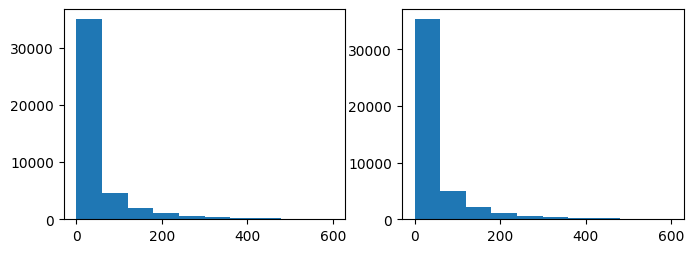

In [398]:
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(2,2,1)
ax.hist(dfA)

ax1 = fig.add_subplot(2,2,2)
ax1.hist(dfB)

plt.show

и без теста видно, что распределение ненормальное , поэтому будет использовать тест манна уитни : 

In [402]:
u_statistic, p_value = mannwhitneyu(dfA , dfB, alternative = 'two-sided')
print(u_statistic, p_value)

1013085404.5 0.03995000307972228


Видим , что при $\alpha$ = 0.05 , мы отвергнем нулевую гипотезу в пользу альтернативной так как `p-value` у нас меньше 0.05

#### Бутстрап

In [428]:
dfA = df.loc[df['version'] == 'gate_30', 'sum_gamerounds']
dfB = df.loc[df['version'] == 'gate_40', 'sum_gamerounds']

In [429]:
dfA_mean = dfA.mean()
dfB_mean = dfB.mean()

seB = np.std(dfB) / np.sqrt(len(dfB))
seA = np.std(dfA) / np.sqrt(len(dfA))

dif = dfB_mean - dfA_mean 
defSe = seB - seA

print(dfA_mean)
print(dfB_mean)
print(dif)
print(defSe)

46.87298659227931
46.43581805718329
-0.4371685350960206
-0.008185041648464286


In [430]:
dfA_boot = np.random.choice(dfA, size = (10000, 9747), replace = True)
dfB_boot = np.random.choice(dfB, size = (10000, 9747), replace = True)

dfA_boot_means = []
dfA_boot_var = []

for i in dfA_boot : 
    m = np.mean(i, axis = 0)
    dfA_boot_means.append(m)
    v = np.var(i, axis = 0)
    dfA_boot_var.append(m)
    


dfB_boot_means = []
dfB_boot_var = []

for i in dfB_boot : 
    m = np.mean(i, axis = 0)
    dfB_boot_means.append(m)
    v = np.var(i, axis = 0)
    dfB_boot_var.append(m)

<function matplotlib.pyplot.show(close=None, block=None)>

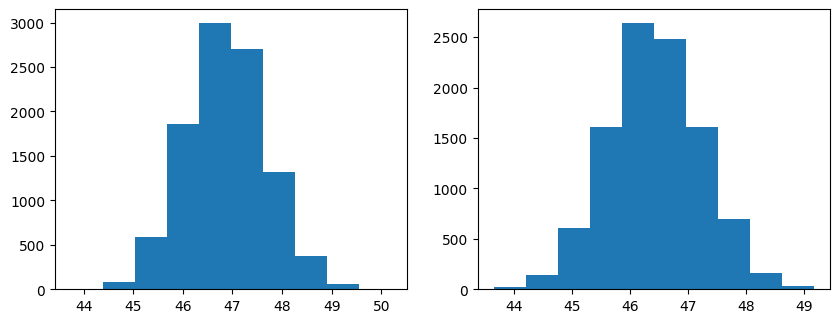

In [431]:
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(2,2,1)
ax.hist(dfA_boot_means)


ax = fig.add_subplot(2,2,2)
ax.hist(dfB_boot_means)

plt.show

In [432]:
t_value = ((np.array(dfB_boot_means) - np.array(dfA_boot_means)) - dif) / (np.sqrt((np.array(dfA_boot_var) + np.array(dfB_boot_var)) / 9747*2))

In [433]:
right = dif + np.quantile(t_value, 1-0.05 / 2)*defSe
left = dif + np.quantile(t_value, 0.05 / 2)*defSe

In [434]:
print(left , right)

-0.30732753517574823 -0.5665556674892398


Видим , что ноль у нас не лежит в нашем интервале => мы отклоняем нулевую гипотезу в пользу альтернативной. 

# Retention after 7 days

Для семидневного ретеншн , также проведем два теста : `z - test` для пропорций и бутстрап. 

#### Бутстрап

In [435]:
dfA = df.loc[df['version'] == 'gate_30', 'retention_7']
dfB = df.loc[df['version'] == 'gate_40', 'retention_7']

dfA_mean = dfA.mean()
dfB_mean = dfB.mean()

dfA_se = np.std(dfA) / np.sqrt(len(dfA))
dfB_se = np.std(dfB) / np.sqrt(len(dfB))

dif_se = dfB_se + dfA_se

dif_mean = dfB_mean - dfB_mean

In [436]:
dfA_boot = np.random.choice(dfA, size = (10000, 9747), replace = True)
dfB_boot = np.random.choice(dfB, size = (10000, 9747), replace = True)

dfA_boot_mean = []
dfA_boot_std = []


dfB_boot_mean = []
dfB_boot_std = []


for i in dfA_boot : 
    m = np.mean(i, axis = 0)
    dfA_boot_mean.append(m)

    s = np.std(i, axis = 0)
    dfA_boot_std.append(s)



for i in dfB_boot : 
    m = np.mean(i, axis = 0)
    dfB_boot_mean.append(m)

    s = np.std(i, axis = 0)
    dfB_boot_std.append(s)



<function matplotlib.pyplot.show(close=None, block=None)>

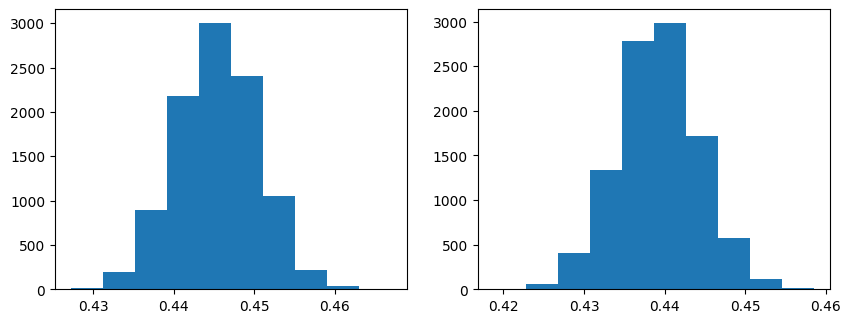

In [437]:
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(2,2,1)
ax.hist(dfA_boot_mean)


ax = fig.add_subplot(2,2,2)
ax.hist(dfB_boot_mean)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

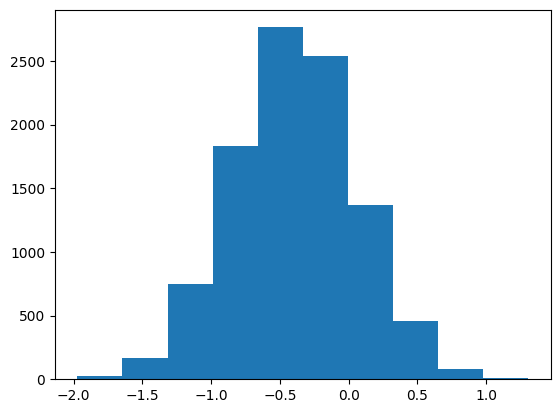

In [439]:
t_value = ((np.array(dfB_boot_mean) - np.array(dfA_boot_mean)) - dif_mean) / ((np.array(dfB_boot_std) + np.array(dfA_boot_std)) / np.sqrt(2000 * 2))
plt.hist(t_value)

plt.show

In [440]:
right , left = dif_mean + np.quantile(t_value , 1-0.05 / 2)*dif_se , dif_mean + np.quantile(t_value , 0.05 / 2)*dif_se
print(left, right)

-0.00591262302019938 0.002267573104412321


Видим , что ноль у нас лежит в нашем интервале => мы не отклоняем нулевую гипотезу в пользу альтернативной. 

#### z - test

In [445]:
table = pd.crosstab(df['version'] , df['retention_7'])
table

success_A = table[0][1]
success_B = table[1][1]

quntity_A = table[0][1] + table[0][0]
quntity_B = table[1][1] + table[1][0]

/var/folders/t9/p_t5rsf92s38bb58_mfpk3rm0000gn/T/ipykernel_27742/761988174.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  success_A = table[0][1]
/var/folders/t9/p_t5rsf92s38bb58_mfpk3rm0000gn/T/ipykernel_27742/761988174.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  success_B = table[1][1]
/var/folders/t9/p_t5rsf92s38bb58_mfpk3rm0000gn/T/ipykernel_27742/761988174.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  quntity

In [449]:
_ , p_value = sm.stats.proportions_ztest([success_A , success_B]  , [quntity_A , quntity_B], alternative = 'two-sided')
p_value

0.06163697914601779

Видим , что при $\alpha$ = 0.05 , у нас `p-v`